In [5]:
!pip install torch torchvision transformers roboflow opencv-python numpy matplotlib



Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTImageProcessor

# Initialize the image processor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Define a transform function that uses the feature extractor
def vit_transform(image):
    # The processor returns a dictionary; we extract the pixel values and remove the batch dimension
    encoding = feature_extractor(images=image, return_tensors='pt')
    return encoding['pixel_values'].squeeze(0)




In [3]:
# Update the path to your dataset folder
dataset_path = r"C:\Users\ravis\Downloads\car detection.v1i.folder"

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=vit_transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "valid"), transform=vit_transform)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

print("Training classes:", train_dataset.classes)


Training classes: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']


In [5]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification

# Ensure train_dataset is loaded
num_classes = len(train_dataset.classes)  # Should be 5 in your case

# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Manually replace classifier layer
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print classifier to confirm correct shape
print(model.classifier)



Linear(in_features=768, out_features=5, bias=True)


In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply this transform to your dataset
train_dataset = datasets.ImageFolder(root=r"C:\Users\ravis\Downloads\car detection.v1i.folder", transform=transform)


In [9]:
print(f"Total Training Images: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")


Total Training Images: 627
Classes: ['test', 'train', 'valid']


In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([8, 3, 224, 224]), Labels: tensor([3, 4, 2, 2, 0, 1, 1, 2])


In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm import tqdm  # Progress bar

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset = datasets.ImageFolder(root=r"C:\Users\ravis\Downloads\car detection.v1i.folder", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load pre-trained ViT model
num_classes = len(train_dataset.classes)  # Ensure correct number of classes
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Modify classifier to match dataset
model.classifier = nn.Linear(model.config.hidden_size, num_classes)
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 3  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Ensure correct format
        loss = criterion(outputs.logits, labels)  # Compute loss manually
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

print("✅ Training Complete!")


Epoch 1/3: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [27:42<00:00, 21.05s/it, loss=0.419]



Epoch 1/3 - Average Loss: 0.8780


Epoch 2/3: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [27:10<00:00, 20.64s/it, loss=0.679]



Epoch 2/3 - Average Loss: 0.5026


Epoch 3/3: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [27:50<00:00, 21.15s/it, loss=0.0908]


Epoch 3/3 - Average Loss: 0.1658
✅ Training Complete!


In [15]:
save_path = os.path.join(dataset_path, "vit_car_detection.pth")
torch.save(model.state_dict(), save_path)
print("Model saved at:", save_path)

Model saved at: C:\Users\ravis\Downloads\car detection.v1i.folder\vit_car_detection.pth


Predicted class: train


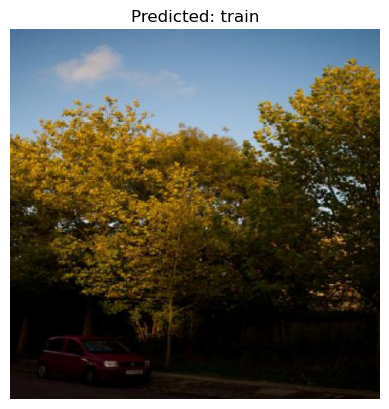

In [23]:
# Load an image for inference (update the path accordingly)
test_image_path = r"C:\Users\ravis\Downloads\car detection.v1i.folder\train\Car\ee2cd94b9d7fdba0_jpg.rf.b062e8faf6fcab368dbe7f5a9ee387fc.jpg"  # Update as needed
image = Image.open(test_image_path).convert("RGB")

# Preprocess the image using the same feature extractor
inputs = feature_extractor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Make a prediction
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

# Map index to actual class name
predicted_class = train_dataset.classes[predicted_class_idx]
print("Predicted class:", predicted_class)

# Visualize the image with its predicted label
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()
